# Models to predict PCE with the descriptros standardized

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import math
import statistics
from scipy.stats import sem
from scipy import stats

from pathlib import Path

import statsmodels.api as sm
from xgboost import XGBRFRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.utils import check_consistent_length
from sklearn.utils import check_array
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from pickle import dump
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(sklearn.__version__)

1.0.2


In [2]:
data = pd.read_csv('descriptors.csv')
print('Number of donor-acceptor pairs is: ' + str(len(data)))

Number of donor-acceptor pairs is: 1001


In [3]:
data_highPCE = data[data['PCE'] > 10]
print('Number of donor-acceptor pairs with a PCE greater than 10% is: ' + str(len(data_highPCE)))

Number of donor-acceptor pairs with a PCE greater than 10% is: 505


## LASSO

In [4]:
# Will tune the descriptors down to 6 until to achieve an optimized RMSE
# returns a list of the top 6 descriptors
def optimize_eq(df, target):
    
    all_descriptors = ['A-HOMO', 'A-HOMOminus1', 'A-LUMO', 'A-LUMOplus1', 'A-fundbg', 'A-deltaHOMO', 'A-deltaLUMO', 'A-opt_bg', 'A-max_abs', 'A-summed_oscs', 'A-area_spectra', 'A-area_sim_solar_spectra', 'A-chemical_potential', 'A-electrophilicity', 'A-pi_sys_size', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'A-NumHAcceptors', 'A-NumHDonors', 'A-planarity','A-dipole_moment', 'A-polarizability', 'A-SolvationEnergy_water', 'A-SolvationEnergy_hexane', 'D-HOMO', 'D-HOMOminus1', 'D-LUMO', 'D-LUMOplus1', 'D-fundbg', 'D-deltaHOMO', 'D-deltaLUMO', 'D-opt_bg', 'D-max_abs', 'D-summed_oscs', 'D-area_spectra', 'D-area_sim_solar_spectra', 'D-chemical_potential', 'D-electrophilicity', 'D-pi_sys_size', 'D-num_rot_bonds', 'D-MolLogP', 'D-TPSA', 'D-NumHAcceptors', 'D-NumHDonors', 'D-planarity','D-dipole_moment', 'D-polarizability', 'D-SolvationEnergy_water', 'D-SolvationEnergy_hexane', 'AD-overlap', 'AD-HOMOoffset', 'AD-LUMOoffset', 'DHOMO_ALUMO_offset']
    
    # LASSO to remove any with coefficients of zero
    descriptors_to_remove = []
    results = evaluate_model(all_descriptors, df[target], df,output=False)
    for x in range(len(results[9])):
        if results[9][x][1] == 0.0:
            descriptors_to_remove.append(results[9][x][0])
            
    for x in descriptors_to_remove:
        all_descriptors.remove(x)
    print(all_descriptors)
    
    while len(all_descriptors) > 6:
        rmse = 100.0
        diff = 0.0
        mae = 100.0
        r2 = -1.00
        for x in range(len(all_descriptors)):
            temp_descriptor = all_descriptors[x]
            new_list = all_descriptors.copy()
            new_list.remove(temp_descriptor)
            results = evaluate_model(new_list, df[target], df,output=False)
            new_diff = 100.0 - float(results[4])
            
            if new_diff >= diff:
                if new_diff == diff:
                    if mae == results[2]:
                        if results[0] > r2:
                            diff = new_diff
                            mae = results[2]
                            r2 = results[0]
                            rmse = results[4]
                            best_list = new_list
                    elif mae > results[2]:
                        diff = new_diff
                        mae = results[2]
                        r2 = results[0]
                        rmse = results[4]
                        best_list = new_list
                else:
                    diff = new_diff
                    mae = results[2]
                    r2 = results[0]
                    rmse = results[4]
                    best_list = new_list
                
        all_descriptors = best_list
        print(len(all_descriptors))
        print(rmse)
        
    print(all_descriptors)
    print(rmse)
    
    return all_descriptors

## from sci-kit-learn https://github.com/scikit-learn/scikit-learn/blob/4773f3e39/sklearn/metrics/_regression.py#L197
def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):

    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def evaluate_model(list_of_desc, target, dataframe, cf = False, output=True):
    '''
    Evaluates the errors of the proposed model
    
    Parameters
    ---------
    list_of_desc = name of the list that contains the descriptors
    target = target experimental value in the dataframe. Ex: df_highPCE['ExperimentalJsc']
    dataframe = name of dataframe to use descriptors from
    cf = should it show the coefficients
    
    Returns
    -------
    R2, MAE, RMSE, MAPE, y-intercept of equation, coefficients of each descriptor, average predictions
    '''
    
    new_df = dataframe[list_of_desc].copy()
    
    max_mae = 10.0
    best_alpha = 0
    for a in range(1,200):
        lm =Lasso(alpha=float(a)/100.0)
        lm.fit(new_df, target)
        mae = mean_absolute_error(target, lm.predict(new_df))
        if mae < max_mae:
            best_alpha = float(a)/100.0
            max_mae = mae

    r2_score = []
    intercepts = []
    coefs = []
    predicted_PCE = []
    MAE_cv = []
    RMSE_cv = []
    
    print('Best alpha is', best_alpha)

    PCE_cv = cross_validate(Lasso(alpha = best_alpha, max_iter = 100000), new_df, target, cv=5, scoring = ['neg_mean_squared_error'] , return_estimator = True)
    for x in PCE_cv['estimator']:
        coef = x.coef_
        coefs.append(coef)

        pred = x.predict(new_df)
        predicted_PCE.append(pred)

        r2_score.append(x.score(new_df, target))
        intercepts.append(x.intercept_)

        
    avg_coef = sum(coefs)/5.0    
    zipped_coefs = zip(list_of_desc, avg_coef)
    
    if output == True:
        if cf == True:
            print('The average intercept from 5 folds is ', statistics.mean(intercepts))
            print('The average coefficients of the 5 folds is ', list(zipped_coefs))
    
    coefficients = list(zipped_coefs)
    
    avg_pred = sum(predicted_PCE)/ 5.0    
    all_mae = []
    all_RMSE = []
    all_MAPE = []
    for x in range(len(predicted_PCE)):
        mae = mean_absolute_error(target, predicted_PCE[x])
        all_mae.append(mae)
        mse = mean_squared_error(target, predicted_PCE[x])
        rmse = math.sqrt(mse)
        all_RMSE.append(rmse)
        mape = mean_absolute_percentage_error(target, predicted_PCE[x]) * 100
        all_MAPE.append(mape)
    SEM_mae = round(sem(all_mae), 3)
    SEM_RMSE = round(sem(all_RMSE), 5)
    SEM_MAPE = round(sem(all_MAPE), 5)
    
    
    mean_MAE = round(statistics.mean(all_mae), 3)
    mean_RMSE = round(statistics.mean(all_RMSE), 4)
    mean_MAPE = round(statistics.mean(all_MAPE), 4)
    SEM_r2 = round(sem(r2_score), 3)
    
    if output == True:
        print('The 5-fold cross-validated RMSE of this model is, ', mean_RMSE, ' +/- ', SEM_RMSE)
        print('The 5-fold cross-validated MAE of the average ', mean_MAE, ' +/- ', SEM_mae)
        print('The average r^2 value is ', statistics.mean(r2_score), ' +/- ', SEM_r2 )
    mean_r2 = round(statistics.mean(r2_score), 3)
    
    intercept = statistics.mean(intercepts)
    
    return mean_r2, SEM_r2, mean_MAE, SEM_mae, mean_RMSE, SEM_RMSE, mean_MAPE, SEM_MAPE, intercept, coefficients, avg_pred

In [35]:
#https://www.programcreek.com/python/example/99249/sklearn.linear_model.LassoCV

def load_default(self, machine_list='basic'):
        """
        Loads 4 different scikit-learn regressors by default. The advanced list adds more machines. 

        Parameters
        ----------
        machine_list: optional, list of strings
            List of default machine names to be loaded.
        Returns
        -------
        self : returns an instance of self.
        """

        if machine_list == 'basic':
            machine_list = ['tree', 'ridge', 'random_forest', 'svm']
        if machine_list == 'advanced':
            machine_list=['lasso', 'tree', 'ridge', 'random_forest', 'svm', 'bayesian_ridge', 'sgd']

        self.estimators_ = {}
        for machine in machine_list:
            try:
                if machine == 'lasso':
                    self.estimators_['lasso'] = linear_model.LassoCV(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'tree':
                    self.estimators_['tree'] = DecisionTreeRegressor(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'ridge':
                    self.estimators_['ridge'] = linear_model.RidgeCV().fit(self.X_k_, self.y_k_)
                if machine == 'random_forest':
                    self.estimators_['random_forest'] = RandomForestRegressor(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'svm':
                    self.estimators_['svm'] = LinearSVR(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'sgd':
                    self.estimators_['sgd'] = linear_model.SGDRegressor(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'bayesian_ridge':
                    self.estimators_['bayesian_ridge'] = linear_model.BayesianRidge().fit(self.X_k_, self.y_k_)
            except ValueError:
                continue
        return self 

Lets see which descriptors LASSO selects:

In [8]:
all_descriptors = ['A-HOMO', 'A-HOMOminus1', 'A-LUMO', 'A-LUMOplus1', 'A-fundbg', 'A-deltaHOMO', 'A-deltaLUMO', 'A-opt_bg', 'A-max_abs', 'A-summed_oscs', 'A-area_spectra', 'A-area_sim_solar_spectra', 'A-chemical_potential', 'A-electrophilicity', 'A-pi_sys_size', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'A-NumHAcceptors', 'A-NumHDonors', 'A-planarity','A-dipole_moment', 'A-polarizability', 'A-SolvationEnergy_water', 'A-SolvationEnergy_hexane', 'D-HOMO', 'D-HOMOminus1', 'D-LUMO', 'D-LUMOplus1', 'D-fundbg', 'D-deltaHOMO', 'D-deltaLUMO', 'D-opt_bg', 'D-max_abs', 'D-summed_oscs', 'D-area_spectra', 'D-area_sim_solar_spectra', 'D-chemical_potential', 'D-electrophilicity', 'D-pi_sys_size', 'D-num_rot_bonds', 'D-MolLogP', 'D-TPSA', 'D-NumHAcceptors', 'D-NumHDonors', 'D-planarity','D-dipole_moment', 'D-polarizability', 'D-SolvationEnergy_water', 'D-SolvationEnergy_hexane', 'AD-overlap', 'AD-HOMOoffset', 'AD-LUMOoffset', 'DHOMO_ALUMO_offset']
print("There are " + str(len(all_descriptors)) + ' descriptors')

There are 54 descriptors


In [102]:
Lasso_PCE = evaluate_model(all_descriptors, data['PCE'], data, cf=True)

Best alpha is 0.01
The average intercept from 5 folds is  -51.57087072184057
The average coefficients of the 5 folds is  [('A-HOMO', 0.0), ('A-HOMOminus1', 0.0), ('A-LUMO', -0.17545975271623135), ('A-LUMOplus1', -0.37452985792697435), ('A-fundbg', 0.0), ('A-deltaHOMO', -2.257287427054922), ('A-deltaLUMO', -0.0010517494440340231), ('A-opt_bg', 0.0), ('A-max_abs', 0.012185671244768142), ('A-summed_oscs', -0.11552792341660978), ('A-area_spectra', -0.0024600261908346815), ('A-area_sim_solar_spectra', 0.06207173287218095), ('A-chemical_potential', 0.0), ('A-electrophilicity', -0.03011792426999103), ('A-pi_sys_size', -0.03922436041426376), ('A-num_rot_bonds', -0.39931444393768434), ('A-MolLogP', 0.3033117383147984), ('A-TPSA', 0.019222160253011905), ('A-NumHAcceptors', 0.06030204224934772), ('A-NumHDonors', 0.0), ('A-planarity', -0.16661875585035552), ('A-dipole_moment', -0.02827826710704328), ('A-polarizability', -0.0011481163925569366), ('A-SolvationEnergy_water', 0.0), ('A-SolvationEnergy

When the coefficient is zero, it means there is no correlation between the descriptor and the PCE, so it can be discarded.  
The following descriptors were zeroed out:
1. HOMO (acc & don)
2. HOMO-1 (acc)
3. fundamental bandgap (acc & don)
4. optical bandgap (acc & don)
5. chemical potential (acc & don)
6. NumHDonors (acc & don)
7. Solvation energies for water and hexane (acc & don)
8. deltaHOMO (don)
9. deltaLUMO (don)
10. HOMO offset between donor and acceptor
11. Offset between donor HOMO and acceptor LUMO

The remaining descriptors are hand-tuned to lower the RMSE

In [19]:
#best_descriptors = optimize_eq(data, 'PCE')
Lasso_PCE = evaluate_model(best_descriptors, data['PCE'], data, cf=True)

['A-LUMO', 'A-LUMOplus1', 'A-deltaHOMO', 'A-deltaLUMO', 'A-max_abs', 'A-summed_oscs', 'A-area_spectra', 'A-area_sim_solar_spectra', 'A-electrophilicity', 'A-pi_sys_size', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'A-NumHAcceptors', 'A-planarity', 'A-dipole_moment', 'A-polarizability', 'D-HOMOminus1', 'D-LUMO', 'D-LUMOplus1', 'D-max_abs', 'D-summed_oscs', 'D-area_spectra', 'D-area_sim_solar_spectra', 'D-electrophilicity', 'D-pi_sys_size', 'D-num_rot_bonds', 'D-MolLogP', 'D-TPSA', 'D-NumHAcceptors', 'D-planarity', 'D-dipole_moment', 'D-polarizability', 'AD-overlap', 'AD-LUMOoffset']


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.781293106398152, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.384951783514225, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.786145665426375, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

34
2.9135


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.383602071324276, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.775178613127537, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.57423568455124, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

33
2.9108


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.301351982651795, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.025165096245473, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7502440586868033, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

32
2.9095


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.306155209224016, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.057061871975748, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7463449306924304, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

31
2.9085


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.001718903598885, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9781181618564005, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7062921895540057, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

30
2.9082


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.071758336947823, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.020821837357289, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7129853078440647, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

29
2.9081


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.42211745480563, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1097545924567385, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.308612215823814, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

28
2.908


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9619208471431193, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8328546311240643, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.075441451432198, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

27
2.9079


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.741228766439235, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7996958278818056, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.026895278819211, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

26
2.9079


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.741228766439235, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7996958278818056, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.026916922037344, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

25
2.9079


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.252493299627531, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2570693885936635, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.369651469778546, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

24
2.908
23
2.908
22
2.908
21
2.9081
20
2.9083
19
2.9085
18
2.9079
17
2.9119
16
2.9155
15
2.9187
14
2.9229
13
2.927
12
2.9388
11
2.9556
10
2.9842
9
3.0081
8
3.0222
7
3.0494
6
3.0993
['A-electrophilicity', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'D-HOMOminus1', 'D-NumHAcceptors']
3.0993
The average intercept from 5 folds is  -51.57087072184057
The average coefficients of the 5 folds is  [('A-HOMO', 0.0), ('A-HOMOminus1', 0.0), ('A-LUMO', -0.17545975271623135), ('A-LUMOplus1', -0.37452985792697435), ('A-fundbg', 0.0), ('A-deltaHOMO', -2.257287427054922), ('A-deltaLUMO', -0.0010517494440340231), ('A-opt_bg', 0.0), ('A-max_abs', 0.012185671244768142), ('A-summed_oscs', -0.11552792341660978), ('A-area_spectra', -0.0024600261908346815), ('A-area_sim_solar_spectra', 0.06207173287218095), ('A-chemical_potential', 0.0), ('A-electrophilicity', -0.03011792426999103), ('A-pi_sys_size', -0.03922436041426376), ('A-num_rot_bonds', -0.39931444393768434), ('A-MolLogP', 0.3033117383147984), ('A-TPSA',

In [103]:
best_descriptors = ['A-electrophilicity', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'D-HOMOminus1', 'D-NumHAcceptors']
Lasso_PCE = evaluate_model(best_descriptors, data['PCE'], data, cf=True)

Best alpha is 0.01
The average intercept from 5 folds is  -36.82762357618022
The average coefficients of the 5 folds is  [('A-electrophilicity', -0.03673272675818182), ('A-num_rot_bonds', -0.3919236925943181), ('A-MolLogP', 0.12724213816888424), ('A-TPSA', 0.010438720700639826), ('D-HOMOminus1', -3.849560022147473), ('D-NumHAcceptors', 0.2502317935054116)]
The 5-fold cross-validated RMSE of this model is,  3.0993  +/-  0.00088
The 5-fold cross-validated MAE of the average  2.389  +/-  0.005
The average r^2 value is  0.3372375057734442  +/-  0.0


Using LASSO and some hand-tuning to narrow it down to 6 descriptors, the RMSE of this model is 3.0993 +/- 0.00088 for the PCE. The $R^2$ is 0.337. The descriptors selected is the electrophilicity index of the acceptor, number of rotatable bonds of the acceptor, MolLogP of the acceptor, TPSA of the acceptor, HOMO-1 of the donor, and number of hydrogen acceptors of the donor

### Performance on PCE > 10%

In [104]:
Lasso_highPCE = evaluate_model(all_descriptors, data_highPCE['PCE'], data_highPCE, cf=True)

Best alpha is 0.01
The average intercept from 5 folds is  -9.755106230909318
The average coefficients of the 5 folds is  [('A-HOMO', 0.0), ('A-HOMOminus1', 0.14587450181053052), ('A-LUMO', 0.0), ('A-LUMOplus1', -0.8664064194319682), ('A-fundbg', 0.0), ('A-deltaHOMO', -1.9513053268745733), ('A-deltaLUMO', -0.2075692764533242), ('A-opt_bg', 0.0), ('A-max_abs', 0.012093334014061), ('A-summed_oscs', -0.26010959924607036), ('A-area_spectra', -0.001228889130884021), ('A-area_sim_solar_spectra', 0.2920244921890385), ('A-chemical_potential', 0.0), ('A-electrophilicity', -0.00972223340845234), ('A-pi_sys_size', -0.006020105349466437), ('A-num_rot_bonds', -0.20373383276074), ('A-MolLogP', 0.052010944326335386), ('A-TPSA', -0.0027253190160774965), ('A-NumHAcceptors', 0.1134797325798953), ('A-NumHDonors', -0.18691497892482584), ('A-planarity', -0.12323717504344753), ('A-dipole_moment', -0.045220084674240976), ('A-polarizability', 0.00019032656827361135), ('A-SolvationEnergy_water', 0.0), ('A-Solva

In [13]:
#best_descriptors = optimize_eq(data_highPCE, 'PCE')
best_descriptors = ['A-HOMOminus1', 'A-LUMOplus1', 'A-num_rot_bonds', 'D-electrophilicity', 'D-TPSA', 'D-NumHAcceptors']
Lasso_PCE = evaluate_model(best_descriptors, data_highPCE['PCE'], data_highPCE, cf=True)

The average intercept from 5 folds is  18.9053333875983
The average coefficients of the 5 folds is  [('A-HOMOminus1', 2.4423791628342655), ('A-LUMOplus1', -1.8505026525125796), ('A-num_rot_bonds', -0.19904991306230863), ('D-electrophilicity', 0.04693050672741837), ('D-TPSA', -0.013340898905082504), ('D-NumHAcceptors', 0.06846537685637383)]
The 5-fold cross-validated RMSE of this model is,  1.4972  +/-  0.00158
The 5-fold cross-validated MAE of the average  1.19  +/-  0.002
The average r^2 value is  0.4005937484240183  +/-  0.001


# Machine Learning

Sets X as all input descriptors and y as the PCE

In [6]:
X = data.iloc[:, 8:]
y = data.iloc[:, 7:8]

Split into training (80%) and testing (20%) sets

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

Standardizes the data so all values are centered around 0 and have variance of the same magnitude

In [8]:
x_labels = x_train.columns

scaler = StandardScaler().fit(x_train[x_labels]) 

x_train[x_labels] = scaler.transform(x_train[x_labels])

x_test[x_labels] = scaler.transform(x_test[x_labels])

Optimize alpha

In [135]:
lasso = LassoCV(cv=5, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
print('Best alpha is ' + str(lasso.alpha_))

print(list(zip(lasso.coef_, X)))
print('R squared training set', round(lasso.score(x_train, y_train), 2))
print('R squared test set', round(lasso.score(x_test, y_test), 2))

Best alpha is 0.015007680190353518
[(-0.0, 'A-HOMO'), (0.0, 'A-HOMOminus1'), (-0.0, 'A-LUMO'), (-0.18356550898138208, 'A-LUMOplus1'), (-0.0, 'A-fundbg'), (-0.4309088211200134, 'A-deltaHOMO'), (-0.0, 'A-deltaLUMO'), (-0.0, 'A-opt_bg'), (0.4429274469223087, 'A-max_abs'), (-0.1450424618330334, 'A-summed_oscs'), (-0.5724597837732708, 'A-area_spectra'), (-0.0, 'A-area_sim_solar_spectra'), (-0.0, 'A-chemical_potential'), (-0.7615723538451237, 'A-electrophilicity'), (-0.7458678113357019, 'A-pi_sys_size'), (-1.386861521651988, 'A-num_rot_bonds'), (1.4120457511917808, 'A-MolLogP'), (0.645794565606799, 'A-TPSA'), (0.3110472062273547, 'A-NumHAcceptors'), (-0.04162046077847243, 'A-NumHDonors'), (-0.04742289248576082, 'A-planarity'), (-0.05591391382973767, 'A-dipole_moment'), (-0.0, 'A-polarizability'), (0.06650270144053748, 'A-SolvationEnergy_water'), (0.1502088025022912, 'A-SolvationEnergy_hexane'), (-0.0, 'D-HOMO'), (-0.9950438773340722, 'D-HOMOminus1'), (-0.0, 'D-LUMO'), (-0.7273710243476105, '

Visualize the optimization of alpha

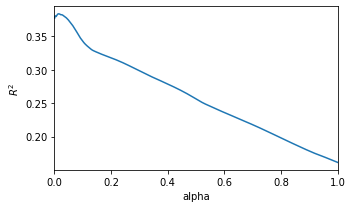

In [97]:
alphas = np.linspace(0.001,1,1000)
lasso = Lasso(max_iter=10000)

scores = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    
    #scores.append(lasso.score(x_train, y_train))
    scores.append(cross_val_score(lasso, x_train, y_train, cv=5).mean())

plt.figure(figsize=(5, 3))  
plt.plot(alphas, scores)
plt.xlim([0, 1])
plt.xlabel('alpha')
plt.ylabel('$R^2$')
plt.tight_layout()
plt.savefig('lasso_cv_alpha.pdf', dpi=600)
plt.show()

Final model metrics

In [2]:
def model_metrics(model, X, y, cv=5):
    score = cross_val_score(model, X, y, cv=cv, scoring = 'r2')
    SEM_r2 = round((score.std() / math.sqrt(5)) , 2)
    #r2 = str(round(score.mean(), 3)) + ' +/- ' +  str(SEM_r2)
    r2 = round(float(score.mean()), 2)
    print('R^2: ' + str(r2) + ' +/- ' +  str(SEM_r2))
    
    score = cross_val_score(model, X, y, cv=cv, scoring = 'neg_mean_absolute_error')
    score = np.multiply(score, -1)
    SEM_MAE = round((score.std() / math.sqrt(5)) , 2)
    #MAE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_MAE)
    MAE = round(score.mean(), 2) 
    print('MAE: ' + str(MAE) + ' +/- ' +  str(SEM_MAE))
    
    score = cross_val_score(model, X, y, cv=cv, scoring = 'neg_mean_squared_error')
    score = np.sqrt(score * -1)
    SEM_RMSE = round((score.std() / math.sqrt(5)) , 2)
    #RMSE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_RMSE)
    RMSE = round(score.mean(), 2)
    print('RMSE: ' + str(RMSE) + ' +/- ' +  str(SEM_RMSE))
    
    return r2, SEM_r2, RMSE, SEM_RMSE

In [136]:
print('Training set')
model_metrics(lasso, x_train, y_train, cv=5)

print('Test set')
model_metrics(lasso, x_test, y_test, cv=5)

Training set
R^2: 0.383 +/- 0.041
MAE: 2.33 +/- 0.09
RMSE: 3.02 +/- 0.09
Test set
R^2: 0.169 +/- 0.031
MAE: 2.49 +/- 0.11
RMSE: 3.23 +/- 0.12


## Random Forest

Find best hyperparameters with randomized search, then use those narrowed down parameters for a gridsearch

In [122]:
rf = RandomForestRegressor(random_state=14)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 50, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 916,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 26,
 'bootstrap': False}

In [138]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 25, 30],
    'max_features': [17, 30],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 100}

In [146]:
rf = RandomForestRegressor(n_estimators=100,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=17, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.486 +/- 0.037
MAE: 2.07 +/- 0.08
RMSE: 2.75 +/- 0.09
test set
R^2: 0.22 +/- 0.013
MAE: 2.37 +/- 0.09
RMSE: 3.13 +/- 0.1


These results are slightly better than LASSO

## Gradient boosting

In [145]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the parameter grid
param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }
# Create a based model
gb = GradientBoostingRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 256 candidates, totalling 768 fits


{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.5}

In [147]:
gb = GradientBoostingRegressor(learning_rate = 0.02, subsample = 0.5, n_estimators = 1000, max_depth=6, random_state=14)

gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.482 +/- 0.036
MAE: 2.05 +/- 0.09
RMSE: 2.76 +/- 0.09
test set
R^2: 0.143 +/- 0.035
MAE: 2.5 +/- 0.13
RMSE: 3.28 +/- 0.15


Random forest is still performing the best

## XGBoost for random forest (XGBRFR)

In [161]:
xgbrfr = XGBRFRegressor(n_estimators=1000, subsample=0.9, colsample_bynode=0.1, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.444 +/- 0.039
MAE: 2.2 +/- 0.08
RMSE: 2.86 +/- 0.09
test set
R^2: 0.214 +/- 0.018
MAE: 2.39 +/- 0.11
RMSE: 3.14 +/- 0.11


## Support Vector Regression (SVR)

In [163]:
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.398 +/- 0.041
MAE: 2.29 +/- 0.08
RMSE: 2.98 +/- 0.09
test set
R^2: 0.162 +/- 0.025
MAE: 2.47 +/- 0.13
RMSE: 3.25 +/- 0.13


## K-nearest neighboors (KNN)

In [172]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.391 +/- 0.026
MAE: 2.25 +/- 0.06
RMSE: 3.0 +/- 0.06
test set
R^2: 0.222 +/- 0.027
MAE: 2.33 +/- 0.1
RMSE: 3.12 +/- 0.11


## LightGBM 

In [17]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=5, num_leaves=2**5, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.371 +/- 0.03
MAE: 2.4 +/- 0.07
RMSE: 3.05 +/- 0.07
test set
R^2: 0.137 +/- 0.013
MAE: 2.53 +/- 0.1
RMSE: 3.29 +/- 0.1


# Performance of models with morgan fingerprints

We can add in morgan fingerprints and see if the performance improves

In [30]:
data = pd.read_csv('descriptors_with_fingerprints.csv')
print('Number of donor-acceptor pairs is: ' + str(len(data)))

Number of donor-acceptor pairs is: 1001


Standardizes the descrptors (not including fingerprints) and then concats the fingerprints

In [50]:
X_unstandardized = data.iloc[:, 8:64]
y = data.iloc[:, 7:8]

#standardize
x_labels = X_unstandardized.columns
scaler = StandardScaler().fit(X_unstandardized[x_labels]) 
X_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])

fps = data.iloc[:,64:]
X = pd.concat([X_unstandardized, fps], axis=1)

In [51]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

## Lasso

In [54]:
lasso = Lasso(alpha=0.01, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
#print('Best alpha is ' + str(lasso.alpha_))

print('training set')
model_metrics(lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(lasso, x_test, y_test, cv=5)

training set
R^2: 0.494 +/- 0.037
MAE: 2.05 +/- 0.07
RMSE: 2.73 +/- 0.09
test set
R^2: 0.019 +/- 0.095
MAE: 2.64 +/- 0.12
RMSE: 3.48 +/- 0.16


## Random Forest

In [55]:
rf = RandomForestRegressor(n_estimators=100,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=17, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.428 +/- 0.035
MAE: 2.26 +/- 0.06
RMSE: 2.91 +/- 0.08
test set
R^2: 0.204 +/- 0.012
MAE: 2.43 +/- 0.1
RMSE: 3.16 +/- 0.09


In [69]:
n_estimators = [10, 100, 500, 1000] 
max_depth = [10, 30, 50, 100]
min_samples_split = [2, 5, 7]
min_samples_leaf = [2, 4, 6]
# max features had the biggest impact
max_features = [30, 40, 50, 60, 70]
for x in max_features:
    print(x)
    rf = RandomForestRegressor(n_estimators=1000,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=50, random_state=14)
    rf.fit(x_train, y_train)
    print('test set')
    model_metrics(rf, x_test, y_test, cv=5)

30
test set
R^2: 0.272 +/- 0.017
MAE: 2.31 +/- 0.11
RMSE: 3.02 +/- 0.11
40
test set
R^2: 0.286 +/- 0.02
MAE: 2.29 +/- 0.11
RMSE: 3.0 +/- 0.11
50
test set
R^2: 0.299 +/- 0.02
MAE: 2.27 +/- 0.11
RMSE: 2.97 +/- 0.11
60
test set
R^2: 0.297 +/- 0.022
MAE: 2.27 +/- 0.11
RMSE: 2.97 +/- 0.11
70
test set
R^2: 0.3 +/- 0.022
MAE: 2.26 +/- 0.11
RMSE: 2.97 +/- 0.11


In [71]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=50, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.503 +/- 0.036
MAE: 2.06 +/- 0.07
RMSE: 2.71 +/- 0.09
test set
R^2: 0.299 +/- 0.02
MAE: 2.27 +/- 0.11
RMSE: 2.97 +/- 0.11


## Gradient Boosting

In [56]:
gb = GradientBoostingRegressor(learning_rate = 0.02, subsample = 0.5, n_estimators = 1000, max_depth=6, random_state=14)

gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.531 +/- 0.04
MAE: 1.93 +/- 0.08
RMSE: 2.63 +/- 0.1
test set
R^2: 0.194 +/- 0.043
MAE: 2.46 +/- 0.14
RMSE: 3.18 +/- 0.15


In [116]:
n_estimators = [90, 100, 110]
subsample = [0.3, 0.5]
learning_rate = [0.015, 0.02, 0.025]
max_depth = [11, 12, 13, 14, 15]

for x in max_depth:
    print(x)
    gb = GradientBoostingRegressor(learning_rate = 0.015, subsample = 0.3, n_estimators = 100, max_depth=12, random_state=14)
    gb.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(gb, x_test, y_test, cv=5)

11
test set
R^2: 0.232 +/- 0.035
MAE: 2.39 +/- 0.13
RMSE: 3.11 +/- 0.13
12
test set
R^2: 0.254 +/- 0.026
MAE: 2.35 +/- 0.12
RMSE: 3.06 +/- 0.12
13
test set
R^2: 0.224 +/- 0.038
MAE: 2.39 +/- 0.13
RMSE: 3.12 +/- 0.14
14
test set
R^2: 0.232 +/- 0.035
MAE: 2.38 +/- 0.13
RMSE: 3.11 +/- 0.13
15
test set
R^2: 0.232 +/- 0.035
MAE: 2.38 +/- 0.13
RMSE: 3.11 +/- 0.13


In [117]:
gb = GradientBoostingRegressor(learning_rate = 0.015, subsample = 0.3, n_estimators = 100, max_depth=12, random_state=14)
gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.481 +/- 0.034
MAE: 2.14 +/- 0.07
RMSE: 2.77 +/- 0.08
test set
R^2: 0.254 +/- 0.026
MAE: 2.35 +/- 0.12
RMSE: 3.06 +/- 0.12


## XGBoost

In [57]:
xgbrfr = XGBRFRegressor(n_estimators=1000, subsample=0.9, colsample_bynode=0.1, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.474 +/- 0.038
MAE: 2.11 +/- 0.07
RMSE: 2.79 +/- 0.09
test set
R^2: 0.255 +/- 0.02
MAE: 2.33 +/- 0.1
RMSE: 3.06 +/- 0.1


In [80]:
n_estimators = [10, 100, 500, 1000, 5000]
subsample = [0.25, 0.3, 0.35]
colsample_bynode = [0.03, 0.02, 0.04]

for x in colsample_bynode:
    print(x)
    xgbrfr = XGBRFRegressor(n_estimators=500, subsample=0.35, colsample_bynode=0.03, random_state=14)
    xgbrfr.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(xgbrfr, x_test, y_test, cv=5)

0.03
test set
R^2: 0.283 +/- 0.018
MAE: 2.29 +/- 0.11
RMSE: 3.0 +/- 0.1
0.02
test set
R^2: 0.277 +/- 0.02
MAE: 2.29 +/- 0.1
RMSE: 3.01 +/- 0.1
0.04
test set
R^2: 0.283 +/- 0.019
MAE: 2.29 +/- 0.1
RMSE: 3.0 +/- 0.1


In [81]:
xgbrfr = XGBRFRegressor(n_estimators=500, subsample=0.35, colsample_bynode=0.03, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.459 +/- 0.035
MAE: 2.17 +/- 0.07
RMSE: 2.83 +/- 0.08
test set
R^2: 0.283 +/- 0.018
MAE: 2.29 +/- 0.11
RMSE: 3.0 +/- 0.1


## SVR

In [58]:
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.279 +/- 0.031
MAE: 2.53 +/- 0.05
RMSE: 3.27 +/- 0.06
test set
R^2: 0.057 +/- 0.019
MAE: 2.61 +/- 0.11
RMSE: 3.44 +/- 0.1


In [105]:
C = [70, 60]
epsilon = [0.35, 0.4, 0.45]
for n in epsilon:
    print(n)
    svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.4)
    svr_rbf.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(svr_rbf, x_test, y_test, cv=5)

0.35
test set
R^2: 0.3 +/- 0.034
MAE: 2.16 +/- 0.06
RMSE: 2.96 +/- 0.09
0.4
test set
R^2: 0.3 +/- 0.034
MAE: 2.16 +/- 0.07
RMSE: 2.96 +/- 0.09
0.45
test set
R^2: 0.3 +/- 0.033
MAE: 2.17 +/- 0.07
RMSE: 2.96 +/- 0.09


In [106]:
svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.4)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.471 +/- 0.041
MAE: 1.99 +/- 0.09
RMSE: 2.79 +/- 0.1
test set
R^2: 0.3 +/- 0.034
MAE: 2.16 +/- 0.07
RMSE: 2.96 +/- 0.09


## KNN

In [59]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.429 +/- 0.049
MAE: 2.1 +/- 0.07
RMSE: 2.9 +/- 0.12
test set
R^2: 0.127 +/- 0.042
MAE: 2.49 +/- 0.13
RMSE: 3.3 +/- 0.11


In [84]:
neighbors = [8, 9, 10, 11, 12]
for n in neighbors:
    print(n)
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(knn, x_test, y_test, cv=5)

8
test set
R^2: 0.266 +/- 0.039
MAE: 2.29 +/- 0.09
RMSE: 3.03 +/- 0.09
9
test set
R^2: 0.279 +/- 0.039
MAE: 2.27 +/- 0.11
RMSE: 3.0 +/- 0.11
10
test set
R^2: 0.292 +/- 0.034
MAE: 2.24 +/- 0.12
RMSE: 2.98 +/- 0.12
11
test set
R^2: 0.305 +/- 0.029
MAE: 2.25 +/- 0.12
RMSE: 2.95 +/- 0.12
12
test set
R^2: 0.274 +/- 0.025
MAE: 2.28 +/- 0.11
RMSE: 3.02 +/- 0.11


In [85]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.434 +/- 0.046
MAE: 2.12 +/- 0.08
RMSE: 2.88 +/- 0.11
test set
R^2: 0.305 +/- 0.029
MAE: 2.25 +/- 0.12
RMSE: 2.95 +/- 0.12


## lightGBM

In [60]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=5, num_leaves=2**5, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.399 +/- 0.027
MAE: 2.32 +/- 0.06
RMSE: 2.98 +/- 0.07
test set
R^2: 0.18 +/- 0.028
MAE: 2.48 +/- 0.08
RMSE: 3.21 +/- 0.1


In [91]:
n_estimators=[10, 100, 500, 1000]
max_depth = [3, 5, 7, 10]
learning_rates = [0.01, 0.1, 0.5]
for x in learning_rates:
    print(x)
    lgbm = LGBMRegressor(n_estimators=10, max_depth=3, num_leaves=2**3, learning_rate=0.1)
    lgbm.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(lgbm, x_test, y_test, cv=5)

0.01
test set
R^2: 0.023 +/- 0.006
MAE: 2.72 +/- 0.1
RMSE: 3.5 +/- 0.09
0.1
test set
R^2: 0.184 +/- 0.025
MAE: 2.47 +/- 0.08
RMSE: 3.2 +/- 0.11
0.5
test set
R^2: 0.125 +/- 0.022
MAE: 2.57 +/- 0.09
RMSE: 3.31 +/- 0.1


In [93]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=3, num_leaves=2**3, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.36 +/- 0.029
MAE: 2.42 +/- 0.07
RMSE: 3.08 +/- 0.07
test set
R^2: 0.184 +/- 0.025
MAE: 2.47 +/- 0.08
RMSE: 3.2 +/- 0.11


## Results

KNN performs the best with fingerprints and without. Let's see how the models improve by only training on PCE above 10 %

In [124]:
data_highPCE = data[data['PCE'] > 10]

X_unstandardized = data_highPCE.iloc[:, 8:64]
y = data_highPCE.iloc[:, 7:8]

#standardize
x_labels = X_unstandardized.columns
scaler = StandardScaler().fit(X_unstandardized[x_labels]) 
X_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])

fps = data_highPCE.iloc[:,64:]
X = pd.concat([X_unstandardized, fps], axis=1)

In [125]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

### Lasso

In [126]:
lasso = Lasso(alpha=0.01, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
#print('Best alpha is ' + str(lasso.alpha_))

print('training set')
model_metrics(lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(lasso, x_test, y_test, cv=5)

training set
R^2: 0.382 +/- 0.026
MAE: 1.16 +/- 0.04
RMSE: 1.48 +/- 0.05
test set
R^2: 0.314 +/- 0.145
MAE: 1.27 +/- 0.1
RMSE: 1.56 +/- 0.13


### RF

In [139]:
n_estimators = [300, 400, 500] 
max_depth = [5, 8, 10]
min_samples_split = [2, 3]
min_samples_leaf = [2, 4, 6]
# max features had the biggest impact
max_features = [56, 57, 58, 59]
for x in max_features:
    print(x)
    rf = RandomForestRegressor(n_estimators=500,max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=14)
    rf.fit(x_train, y_train)
    print('test set')
    model_metrics(rf, x_test, y_test, cv=5)

56
test set
R^2: 0.412 +/- 0.093
MAE: 1.21 +/- 0.1
RMSE: 1.47 +/- 0.12
57
test set
R^2: 0.422 +/- 0.089
MAE: 1.2 +/- 0.1
RMSE: 1.45 +/- 0.11
58
test set
R^2: 0.415 +/- 0.088
MAE: 1.21 +/- 0.09
RMSE: 1.46 +/- 0.11
59
test set
R^2: 0.414 +/- 0.093
MAE: 1.21 +/- 0.1
RMSE: 1.46 +/- 0.11


In [140]:
rf = RandomForestRegressor(n_estimators=500,max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.438 +/- 0.023
MAE: 1.13 +/- 0.04
RMSE: 1.41 +/- 0.05
test set
R^2: 0.422 +/- 0.089
MAE: 1.2 +/- 0.1
RMSE: 1.45 +/- 0.11


### GB

In [147]:
n_estimators = [10, 100, 500, 1000]
subsample = [0.1, 0.2, 0.3]
learning_rate = [0.02, 0.01, 0.03]
max_depth = [11, 12, 13, 14, 15]

for x in max_depth:
    print(x)
    gb = GradientBoostingRegressor(learning_rate = 0.01, subsample = 0.3, n_estimators = 500, max_depth=12, random_state=14)
    gb.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(gb, x_test, y_test, cv=5)

11
test set
R^2: 0.423 +/- 0.115
MAE: 1.15 +/- 0.12
RMSE: 1.43 +/- 0.12
12
test set
R^2: 0.424 +/- 0.112
MAE: 1.15 +/- 0.11
RMSE: 1.43 +/- 0.12
13
test set
R^2: 0.424 +/- 0.114
MAE: 1.14 +/- 0.12
RMSE: 1.43 +/- 0.12
14
test set
R^2: 0.424 +/- 0.114
MAE: 1.14 +/- 0.12
RMSE: 1.43 +/- 0.12
15
test set
R^2: 0.424 +/- 0.114
MAE: 1.14 +/- 0.12
RMSE: 1.43 +/- 0.12


In [148]:
gb = GradientBoostingRegressor(learning_rate = 0.01, subsample = 0.3, n_estimators = 500, max_depth=12, random_state=14)
gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.401 +/- 0.025
MAE: 1.13 +/- 0.03
RMSE: 1.46 +/- 0.04
test set
R^2: 0.424 +/- 0.112
MAE: 1.15 +/- 0.11
RMSE: 1.43 +/- 0.12


### XGBRFR

In [154]:
n_estimators = [10, 100, 500, 1000, 5000]
subsample = [0.55, 0.6, 0.65, 0.8]
colsample_bynode = [0.03, 0.04, 0.05]

for x in colsample_bynode:
    print(x)
    xgbrfr = XGBRFRegressor(n_estimators=100, subsample=0.6, colsample_bynode=0.04, random_state=14)
    xgbrfr.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(xgbrfr, x_test, y_test, cv=5)

0.03
test set
R^2: 0.426 +/- 0.099
MAE: 1.19 +/- 0.09
RMSE: 1.44 +/- 0.12
0.04
test set
R^2: 0.429 +/- 0.097
MAE: 1.18 +/- 0.09
RMSE: 1.44 +/- 0.1
0.05
test set
R^2: 0.414 +/- 0.102
MAE: 1.2 +/- 0.09
RMSE: 1.45 +/- 0.11


In [155]:
xgbrfr = XGBRFRegressor(n_estimators=100, subsample=0.6, colsample_bynode=0.04, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.43 +/- 0.021
MAE: 1.13 +/- 0.03
RMSE: 1.42 +/- 0.05
test set
R^2: 0.429 +/- 0.097
MAE: 1.18 +/- 0.09
RMSE: 1.44 +/- 0.1


### SVR

In [162]:
C = [65, 70, 75]
epsilon = [0.1, 0.15, 0.2]
for x in epsilon:
    print(x)
    svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.2)
    svr_rbf.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(svr_rbf, x_test, y_test, cv=5)

0.1
test set
R^2: 0.475 +/- 0.125
MAE: 1.07 +/- 0.11
RMSE: 1.35 +/- 0.15
0.15
test set
R^2: 0.476 +/- 0.123
MAE: 1.07 +/- 0.11
RMSE: 1.35 +/- 0.15
0.2
test set
R^2: 0.476 +/- 0.122
MAE: 1.07 +/- 0.11
RMSE: 1.35 +/- 0.15


In [163]:
svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.2)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.41 +/- 0.045
MAE: 1.11 +/- 0.03
RMSE: 1.44 +/- 0.04
test set
R^2: 0.476 +/- 0.122
MAE: 1.07 +/- 0.11
RMSE: 1.35 +/- 0.15


### KNN

In [164]:
neighbors = [8, 9, 10, 11, 12]
for n in neighbors:
    print(n)
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(knn, x_test, y_test, cv=5)

8
test set
R^2: 0.396 +/- 0.103
MAE: 1.22 +/- 0.08
RMSE: 1.48 +/- 0.1
9
test set
R^2: 0.4 +/- 0.101
MAE: 1.22 +/- 0.08
RMSE: 1.48 +/- 0.11
10
test set
R^2: 0.417 +/- 0.105
MAE: 1.2 +/- 0.08
RMSE: 1.45 +/- 0.11
11
test set
R^2: 0.421 +/- 0.098
MAE: 1.21 +/- 0.09
RMSE: 1.45 +/- 0.11
12
test set
R^2: 0.411 +/- 0.101
MAE: 1.23 +/- 0.09
RMSE: 1.46 +/- 0.11


In [165]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.37 +/- 0.04
MAE: 1.17 +/- 0.04
RMSE: 1.49 +/- 0.04
test set
R^2: 0.421 +/- 0.098
MAE: 1.21 +/- 0.09
RMSE: 1.45 +/- 0.11


### lightGBM

In [177]:
n_estimators=[49, 50, 51, 52, 53]
max_depth = [3, 5, 7, 10]
learning_rates = [0.15, 0.2, 0.25]
for x in learning_rates:
    print(x)
    lgbm = LGBMRegressor(n_estimators=51, max_depth=3, num_leaves=2**3, learning_rate=0.2)
    lgbm.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(lgbm, x_test, y_test, cv=5)

0.15
test set
R^2: 0.329 +/- 0.143
MAE: 1.25 +/- 0.12
RMSE: 1.54 +/- 0.14
0.2
test set
R^2: 0.342 +/- 0.157
MAE: 1.21 +/- 0.13
RMSE: 1.52 +/- 0.15
0.25
test set
R^2: 0.324 +/- 0.154
MAE: 1.23 +/- 0.13
RMSE: 1.54 +/- 0.15


In [178]:
lgbm = LGBMRegressor(n_estimators=51, max_depth=3, num_leaves=2**3, learning_rate=0.2)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.35 +/- 0.025
MAE: 1.16 +/- 0.03
RMSE: 1.52 +/- 0.04
test set
R^2: 0.342 +/- 0.157
MAE: 1.21 +/- 0.13
RMSE: 1.52 +/- 0.15


# Using Morgan FP Counts with PCE>10%

In [3]:
data = pd.read_csv('descriptors_with_fingerprints_counts.csv')
print('Number of donor-acceptor pairs is: ' + str(len(data)))

Number of donor-acceptor pairs is: 999


In [4]:
data_highPCE = data[data['PCE'] > 10]

X_unstandardized = data_highPCE.iloc[:, 8:64]
y = data_highPCE.iloc[:, 7:8]

#standardize
x_labels = X_unstandardized.columns
scaler = StandardScaler().fit(X_unstandardized[x_labels]) 
X_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])

fps = data_highPCE.iloc[:,64:]
X = pd.concat([X_unstandardized, fps], axis=1)

dump(scaler, open('scaler.pkl', 'wb'))

In [5]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

In [6]:
x_test

,A-HOMO,A-HOMOminus1,A-LUMO,A-LUMOplus1,A-fundbg,A-deltaHOMO,A-deltaLUMO,A-opt_bg,A-max_abs,A-summed_oscs,...,D-ECFP_2038,D-ECFP_2039,D-ECFP_2040,D-ECFP_2041,D-ECFP_2042,D-ECFP_2043,D-ECFP_2044,D-ECFP_2045,D-ECFP_2046,D-ECFP_2047
817,-0.078408,1.539964,0.339081,-0.920729,0.285203,-2.477023,-2.375402,0.708746,-1.521699,3.948174,...,0,0,0,0,0,0,0,0,0,0
635,-0.430541,-0.614192,0.272551,0.475998,0.617681,0.480279,0.428974,0.403589,-0.412541,-0.263237,...,0,0,0,0,0,0,0,0,0,0
26,1.494457,2.733393,1.179022,-0.195357,-0.875991,-2.600890,-2.479268,1.013902,-2.589776,7.647295,...,0,0,0,0,0,0,0,0,0,0
512,-0.975175,-0.986515,-1.324167,-1.028764,0.240542,0.459634,0.384460,0.174722,-0.115853,-0.242525,...,0,0,0,0,0,0,0,0,0,0
62,0.527263,-0.464598,0.264235,0.460564,-0.399604,1.300891,0.414136,-1.427350,1.897062,-0.340025,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.207995,1.057938,-0.700449,-1.267982,-0.637797,-1.413840,-1.188365,-0.283013,0.450137,-0.101464,...,0,0,0,0,0,0,0,0,0,0
920,0.353543,0.851831,0.463825,0.151895,-0.096899,-0.933859,-0.535494,-0.130435,0.226479,-0.013003,...,0,0,0,0,0,0,0,0,0,0
723,-0.411761,-0.624165,0.239286,0.468281,0.577982,0.516406,0.473488,0.327300,-0.339510,-0.664714,...,0,0,0,0,0,0,0,0,0,0
747,-0.608956,-1.584892,1.511671,1.880441,1.545644,1.791194,0.918627,0.403589,-0.417106,-0.972167,...,0,0,0,0,0,0,0,0,0,0


## LASSO

In [9]:
lasso = LassoCV(cv=5, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
print('Best alpha is ' + str(lasso.alpha_))

Best alpha is 0.046476054722918166


In [10]:
lasso = Lasso(alpha=0.046476, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)

print('training set')
model_metrics(lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(lasso, x_test, y_test, cv=5)

# save the model
dump(lasso, open('lasso_mfcounts_standardized_above10.pkl', 'wb'))


training set
R^2: 0.45 +/- 0.03
MAE: 1.07 +/- 0.03
RMSE: 1.38 +/- 0.05
test set
R^2: -0.09 +/- 0.13
MAE: 1.48 +/- 0.14
RMSE: 1.95 +/- 0.17


In [11]:
lasso_predictions_test = lasso.predict(x_test)
lasso_predictions_train = lasso.predict(x_train)

print(lasso_predictions_test.max())
print(lasso_predictions_train.max())

16.06020705119034
16.201249166415465


### RF

In [15]:
n_estimators = [50, 60, 70, 80, 90, 100, 110, 120] 
max_depth = [5, 8, 10]
min_samples_split = [2, 3]
min_samples_leaf = [2, 4, 6]
# max features had the biggest impact
max_features = [30, 50, 56, 57, 58, 59, 70, 100]
for x in max_features:
    print(x)
    rf = RandomForestRegressor(n_estimators=80,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
    rf.fit(x_train, y_train)
    print('test set')
    model_metrics(rf, x_test, y_test, cv=5)

30
test set
R^2: 0.323 +/- 0.063
MAE: 1.29 +/- 0.16
RMSE: 1.58 +/- 0.19
50
test set
R^2: 0.351 +/- 0.06
MAE: 1.24 +/- 0.16
RMSE: 1.55 +/- 0.2
56
test set
R^2: 0.388 +/- 0.061
MAE: 1.21 +/- 0.16
RMSE: 1.51 +/- 0.2
57
test set
R^2: 0.399 +/- 0.073
MAE: 1.2 +/- 0.16
RMSE: 1.5 +/- 0.21
58
test set
R^2: 0.368 +/- 0.07
MAE: 1.23 +/- 0.17
RMSE: 1.54 +/- 0.21
59
test set
R^2: 0.37 +/- 0.083
MAE: 1.22 +/- 0.16
RMSE: 1.53 +/- 0.21
70
test set
R^2: 0.365 +/- 0.072
MAE: 1.22 +/- 0.16
RMSE: 1.54 +/- 0.2
100
test set
R^2: 0.368 +/- 0.07
MAE: 1.23 +/- 0.16
RMSE: 1.53 +/- 0.2


In [12]:
rf = RandomForestRegressor(n_estimators=80,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
rf.fit(x_train, y_train)
print('training set')
R2_train, R2_SEM_train, RMSE_train, RMSE_SEM_train = model_metrics(rf, x_train, y_train, cv=5)
print('test set')
R2_test, R2_SEM_test, RMSE_test, RMSE_SEM_test = model_metrics(rf, x_test, y_test, cv=5)

# save the model
dump(rf, open('rf_mfcounts_standardized_above10.pkl', 'wb'))

training set
R^2: 0.47 +/- 0.03
MAE: 1.09 +/- 0.02
RMSE: 1.36 +/- 0.03
test set
R^2: 0.4 +/- 0.07
MAE: 1.2 +/- 0.16
RMSE: 1.5 +/- 0.21


In [13]:
rf_predictions_test = rf.predict(x_test)
rf_predictions_train = rf.predict(x_train)

print(rf_predictions_test.max())
print(rf_predictions_train.max())

15.721787572434812
15.853514178386632


In [24]:
x_test['predictions'] = rf_predictions_test
x_train['predictions'] = rf_predictions_train
#x_test.to_csv('rf_test_predictions.csv')
#x_train.to_csv('rf_train_predictions.csv')

KeyError: 5

In [35]:
predicted_PCE = []
for x in data_highPCE.index:
    try:
        predicted_PCE.append(x_test.loc[x][-1])
    except:
        predicted_PCE.append(x_train.loc[x][-1])
        

data_highPCE['predicted_PCE'] = predicted_PCE
data_highPCE.to_csv('rf_desc_with_predictions.csv')
data_highPCE


,Unnamed: 0,acceptor,donor,reference,Voc,Jsc,FF,PCE,A-HOMO,A-HOMOminus1,...,D-ECFP_2039,D-ECFP_2040,D-ECFP_2041,D-ECFP_2042,D-ECFP_2043,D-ECFP_2044,D-ECFP_2045,D-ECFP_2046,D-ECFP_2047,predicted_PCE
0,0,2FIFIC,PBDB-TF,Zhang_preparation_2020,0.800,22.40,61.50,11.34,-13.838,-14.653,...,0,0,0,0,0,0,0,0,0,11.779392
1,1,2T2Se-F,PBDB-TF,Ding_selenophene_2022,0.875,20.63,66.90,12.05,-13.067,-13.891,...,0,0,0,0,0,0,0,0,0,12.121231
2,2,3TT-OCIC,PTB7-Th,Gao_achieving_2019,0.680,26.49,69.00,12.43,-13.392,-14.307,...,0,2,0,0,0,0,0,0,0,12.124100
3,3,4T-1,D18,Zhou_high-efficiency_2021,0.930,18.28,70.97,12.04,-13.948,-14.850,...,0,0,0,0,0,0,0,0,0,11.959549
4,4,4T-1,PBDB-T,Zhou_high-efficiency_2021,0.810,17.27,72.45,10.15,-13.948,-14.850,...,0,0,0,0,0,0,0,0,0,11.275350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,991,ZITI,J100,Wang_a wide-bandgap_2019,0.937,21.25,72.48,14.43,-14.090,-14.696,...,0,0,0,0,0,0,0,0,0,12.869792
992,992,ZITI,PBDB-T,Liu_design_2018,0.890,19.80,74.04,13.03,-14.090,-14.696,...,0,0,0,0,0,0,0,0,0,11.928313
993,993,ZITI-C,J71,Zhang_revealing_2019,0.851,21.30,72.76,13.18,-14.184,-14.785,...,0,0,0,0,0,0,0,0,0,12.259730
995,995,ZITI-N,J71,Zhang_revealing_2019,0.876,21.78,72.00,13.68,-14.086,-14.504,...,0,0,0,0,0,0,0,0,0,12.150411


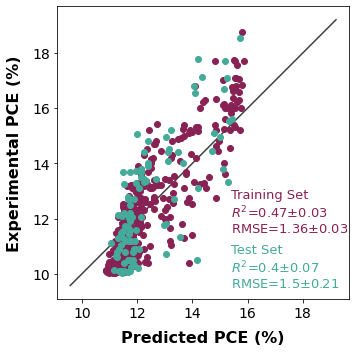

In [67]:
fig, ax = plt.subplots(figsize = (5.5, 5))
ax.scatter(rf_predictions_train, y_train, color = '#882255')
ax.scatter(rf_predictions_test, y_test, color = '#44AA99')


#ax.plot(sTDA_HOMOs_array, m*sTDA_HOMOs_array + b, color='c', linewidth=5)

# x=y line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax.set_ylabel('Experimental PCE (%)', labelpad=10, weight='bold', size=16)
ax.set_xlabel('Predicted PCE (%)', labelpad=10, weight='bold', size=16)
ax.tick_params(axis = 'x', labelsize=14)
ax.tick_params(axis = 'y', labelsize=14)


text_train = 'Training Set\n$R^2$=' + str(R2_train) + '$\pm$' + str(R2_SEM_train) + '\nRMSE=' + str(RMSE_train)+ '$\pm$' + str(RMSE_SEM_train)
text_test = 'Test Set\n$R^2$=' + str(R2_test) + '$\pm$' + str(R2_SEM_test) + '\nRMSE=' + str(RMSE_test)+ '$\pm$' + str(RMSE_SEM_test)

ax.text(15.4, 11.5, text_train, ha='left', size=13, color='#882255')
ax.text(15.4, 9.5, text_test, ha='left', size=13, color='#44AA99')
ax.set_aspect('equal')
plt.tight_layout()

plt.savefig('rf_predictions_scatter_MFcounts_standardized.pdf', dpi=600)
plt.savefig('rf_predictions_scatter_MFcounts_standardized.png', dpi=600)
plt.show()

### GB

In [21]:
n_estimators = [200, 250, 300]
subsample = [0.1, 0.2, 0.3]
learning_rate = [0.02, 0.01, 0.03]
max_depth = [5, 6, 7, 8, 9 , 10, 11]

for x in max_depth:
    print(x)
    gb = GradientBoostingRegressor(learning_rate = 0.01, subsample =0.2, n_estimators = 250, max_depth=7, random_state=20)
    gb.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(gb, x_test, y_test, cv=5)

5
test set
R^2: 0.348 +/- 0.079
MAE: 1.25 +/- 0.17
RMSE: 1.56 +/- 0.21
6
test set
R^2: 0.342 +/- 0.075
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.2
7
test set
R^2: 0.35 +/- 0.069
MAE: 1.25 +/- 0.17
RMSE: 1.56 +/- 0.2
8
test set
R^2: 0.347 +/- 0.073
MAE: 1.25 +/- 0.17
RMSE: 1.56 +/- 0.2
9
test set
R^2: 0.347 +/- 0.077
MAE: 1.25 +/- 0.17
RMSE: 1.56 +/- 0.21
10
test set
R^2: 0.348 +/- 0.076
MAE: 1.25 +/- 0.17
RMSE: 1.56 +/- 0.21
11
test set
R^2: 0.348 +/- 0.076
MAE: 1.25 +/- 0.17
RMSE: 1.56 +/- 0.21


In [9]:
gb = GradientBoostingRegressor(learning_rate = 0.01, subsample =0.2, n_estimators = 250, max_depth=7, random_state=20)
gb.fit(x_train, y_train.values.ravel())
print('training set')
R2_train, R2_SEM_train, RMSE_train, RMSE_SEM_train = model_metrics(gb, x_train, y_train, cv=5)
print('test set')
R2_test, R2_SEM_test, RMSE_test, RMSE_SEM_test = model_metrics(gb, x_test, y_test, cv=5)

# save the model
dump(gb, open('gb_mfcounts_standardized_above10.pkl', 'wb'))

training set
R^2: 0.47 +/- 0.03
MAE: 1.09 +/- 0.04
RMSE: 1.36 +/- 0.04
test set
R^2: 0.35 +/- 0.07
MAE: 1.25 +/- 0.17
RMSE: 1.56 +/- 0.2


In [8]:
gb_predictions_test = gb.predict(x_test)
gb_predictions_train = gb.predict(x_train)

print(gb_predictions_test.max())
print(gb_predictions_train.max())

16.246745166044597
16.30684851774687


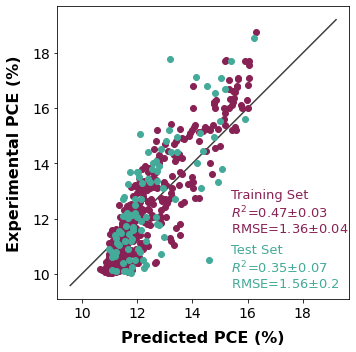

In [10]:
fig, ax = plt.subplots(figsize = (5.5, 5))
ax.scatter(gb_predictions_train, y_train, color = '#882255')
ax.scatter(gb_predictions_test, y_test, color = '#44AA99')


#ax.plot(sTDA_HOMOs_array, m*sTDA_HOMOs_array + b, color='c', linewidth=5)

# x=y line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax.set_ylabel('Experimental PCE (%)', labelpad=10, weight='bold', size=16)
ax.set_xlabel('Predicted PCE (%)', labelpad=10, weight='bold', size=16)
ax.tick_params(axis = 'x', labelsize=14)
ax.tick_params(axis = 'y', labelsize=14)


text_train = 'Training Set\n$R^2$=' + str(R2_train) + '$\pm$' + str(R2_SEM_train) + '\nRMSE=' + str(RMSE_train)+ '$\pm$' + str(RMSE_SEM_train)
text_test = 'Test Set\n$R^2$=' + str(R2_test) + '$\pm$' + str(R2_SEM_test) + '\nRMSE=' + str(RMSE_test)+ '$\pm$' + str(RMSE_SEM_test)

ax.text(15.4, 11.5, text_train, ha='left', size=13, color='#882255')
ax.text(15.4, 9.5, text_test, ha='left', size=13, color='#44AA99')
ax.set_aspect('equal')
plt.tight_layout()

plt.savefig('gb_predictions_scatter_MFcounts_standardized.pdf', dpi=600)
plt.savefig('gb_predictions_scatter_MFcounts_standardized.png', dpi=600)
plt.show()

### XGBRFR

In [28]:
n_estimators = [75, 100, 150]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
colsample_bynode = [0.03, 0.04, 0.05]

for x in colsample_bynode:
    print(x)
    xgbrfr = XGBRFRegressor(n_estimators=75, subsample=0.4, colsample_bynode=0.04, random_state=22)
    xgbrfr.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(xgbrfr, x_test, y_test, cv=5)

0.03
test set
R^2: 0.363 +/- 0.065
MAE: 1.23 +/- 0.17
RMSE: 1.54 +/- 0.21
0.04
test set
R^2: 0.373 +/- 0.066
MAE: 1.22 +/- 0.17
RMSE: 1.53 +/- 0.21
0.05
test set
R^2: 0.356 +/- 0.072
MAE: 1.24 +/- 0.17
RMSE: 1.55 +/- 0.21


In [19]:
xgbrfr = XGBRFRegressor(n_estimators=75, subsample=0.4, colsample_bynode=0.04, random_state=22)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

# save the model
dump(xgbrfr, open('xgbrfr_mfcounts_standardized_above10.pkl', 'wb'))

XGBoostError: sklearn needs to be installed in order to use this module

In [20]:
xgbrfr_predictions_test = xgbrfr.predict(x_test)

### SVR

In [36]:
C = [1, 10, 15, 20]
epsilon = [0.75, 0.9, 1, 1.5, 3]
for x in epsilon:
    print(x)
    svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.75)
    svr_rbf.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(svr_rbf, x_test, y_test, cv=5)

0.75
test set
R^2: 0.193 +/- 0.116
MAE: 1.38 +/- 0.14
RMSE: 1.7 +/- 0.2
0.9
test set
R^2: 0.191 +/- 0.111
MAE: 1.39 +/- 0.15
RMSE: 1.7 +/- 0.2
1
test set
R^2: 0.188 +/- 0.108
MAE: 1.39 +/- 0.15
RMSE: 1.71 +/- 0.2
1.5
test set
R^2: 0.149 +/- 0.083
MAE: 1.43 +/- 0.15
RMSE: 1.76 +/- 0.2
3
test set
R^2: -0.154 +/- 0.113
MAE: 1.73 +/- 0.17
RMSE: 2.01 +/- 0.17


In [16]:
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.75)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

# save the model
dump(svr_rbf, open('svr_mfcounts_standardized_above10.pkl', 'wb'))

training set
R^2: 0.4 +/- 0.02
MAE: 1.15 +/- 0.02
RMSE: 1.45 +/- 0.03
test set
R^2: 0.19 +/- 0.12
MAE: 1.38 +/- 0.14
RMSE: 1.7 +/- 0.2


In [17]:
svr_rbf_predictions_test = svr_rbf.predict(x_test)
svr_rbf_predictions_train = svr_rbf.predict(x_train)

print(svr_rbf_predictions_test.max())
print(svr_rbf_predictions_train.max())

15.08194630080704
15.151454502260917


### KNN

In [38]:
neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for n in neighbors:
    print(n)
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(knn, x_test, y_test, cv=5)

2
test set
R^2: -0.186 +/- 0.091
MAE: 1.66 +/- 0.14
RMSE: 2.06 +/- 0.21
3
test set
R^2: -0.004 +/- 0.129
MAE: 1.51 +/- 0.14
RMSE: 1.87 +/- 0.2
4
test set
R^2: 0.165 +/- 0.108
MAE: 1.42 +/- 0.14
RMSE: 1.7 +/- 0.16
5
test set
R^2: 0.196 +/- 0.131
MAE: 1.38 +/- 0.15
RMSE: 1.68 +/- 0.19
6
test set
R^2: 0.177 +/- 0.161
MAE: 1.38 +/- 0.17
RMSE: 1.68 +/- 0.21
7
test set
R^2: 0.167 +/- 0.18
MAE: 1.39 +/- 0.18
RMSE: 1.68 +/- 0.22
8
test set
R^2: 0.196 +/- 0.161
MAE: 1.37 +/- 0.16
RMSE: 1.65 +/- 0.2
9
test set
R^2: 0.163 +/- 0.168
MAE: 1.39 +/- 0.16
RMSE: 1.69 +/- 0.21
10
test set
R^2: 0.18 +/- 0.163
MAE: 1.38 +/- 0.16
RMSE: 1.68 +/- 0.21
11
test set
R^2: 0.184 +/- 0.171
MAE: 1.37 +/- 0.17
RMSE: 1.68 +/- 0.23
12
test set
R^2: 0.181 +/- 0.164
MAE: 1.37 +/- 0.18
RMSE: 1.69 +/- 0.22


In [18]:
knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

# save the model
dump(knn, open('knn_mfcounts_standardized_above10.pkl', 'wb'))

training set
R^2: 0.38 +/- 0.03
MAE: 1.17 +/- 0.02
RMSE: 1.47 +/- 0.02
test set
R^2: 0.2 +/- 0.16
MAE: 1.37 +/- 0.16
RMSE: 1.65 +/- 0.2


In [19]:
knn_predictions_test = knn.predict(x_test)
knn_predictions_train = knn.predict(x_train)

print(knn_predictions_test.max())
print(knn_predictions_train.max())

16.353749999999998
16.415


### lightGBM

In [43]:
n_estimators=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 50, 100]
max_depth = [3, 5, 7, 10]
learning_rates = [0.25, 0.3, 0.4, 0.5, 0.6]
for x in learning_rates:
    print(x)
    lgbm = LGBMRegressor(n_estimators=11, max_depth=3, num_leaves=2**3, learning_rate=0.25)
    lgbm.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(lgbm, x_test, y_test, cv=5)

0.25
test set
R^2: 0.323 +/- 0.065
MAE: 1.29 +/- 0.16
RMSE: 1.58 +/- 0.19
0.3
test set
R^2: 0.289 +/- 0.057
MAE: 1.32 +/- 0.16
RMSE: 1.62 +/- 0.19
0.4
test set
R^2: 0.249 +/- 0.076
MAE: 1.35 +/- 0.16
RMSE: 1.65 +/- 0.19
0.5
test set
R^2: 0.192 +/- 0.066
MAE: 1.41 +/- 0.17
RMSE: 1.72 +/- 0.19
0.6
test set
R^2: 0.104 +/- 0.073
MAE: 1.45 +/- 0.14
RMSE: 1.78 +/- 0.15


In [20]:
lgbm = LGBMRegressor(n_estimators=11, max_depth=3, num_leaves=2**3, learning_rate=0.25)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

# save the model
dump(lgbm, open('lgbm_mfcounts_standardized_above10.pkl', 'wb'))

training set
R^2: 0.45 +/- 0.03
MAE: 1.09 +/- 0.02
RMSE: 1.39 +/- 0.04
test set
R^2: 0.32 +/- 0.07
MAE: 1.29 +/- 0.16
RMSE: 1.58 +/- 0.19


In [21]:
lgbm_predictions_test = lgbm.predict(x_test)
lgbm_predictions_train = lgbm.predict(x_train)

print(lgbm_predictions_test.max())
print(lgbm_predictions_train.max())

16.084952770940486
16.1767111612109


### ANN

In [47]:
ann = MLPRegressor(random_state=1, max_iter=500)
ann.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(ann, x_train, y_train, cv=5)
print('test set')
model_metrics(ann, x_test, y_test, cv=5)

training set
R^2: 0.036 +/- 0.171
MAE: 1.35 +/- 0.1
RMSE: 1.8 +/- 0.15
test set
R^2: -0.587 +/- 0.351
MAE: 1.72 +/- 0.03
RMSE: 2.21 +/- 0.06


In [48]:
ann = MLPRegressor()
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}


grid_search = GridSearchCV(estimator = ann, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [22]:
ann = MLPRegressor(hidden_layer_sizes = (50, 50, 50), learning_rate = 'adaptive', random_state=14, max_iter=500)
ann.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(ann, x_train, y_train, cv=5)
print('test set')
model_metrics(ann, x_test, y_test, cv=5)

# save the model
dump(ann, open('ann_mfcounts_standardized_above10.pkl', 'wb'))

training set
R^2: 0.04 +/- 0.12
MAE: 1.32 +/- 0.08
RMSE: 1.69 +/- 0.14
test set
R^2: -0.51 +/- 0.48
MAE: 1.6 +/- 0.07
RMSE: 2.07 +/- 0.07


In [23]:
ann_predictions_test = ann.predict(x_test)
ann_predictions_train = ann.predict(x_train)

print(ann_predictions_test.max())
print(ann_predictions_train.max())

16.73551840306628
17.772325287009014


# Ensemble models

### Ensemble models with LASSO, just averging the predictions

In [25]:
lasso_rf = []
lasso_gb = []
lasso_xbg = []
lasso_svr = []
lasso_knn = []
lasso_lgbm = []
lasso_ann = []

for x in range(len(x_test)):
    lasso = lasso_predictions_test[x]
    rf = rf_predictions_test[x]
    gb = gb_predictions_test[x]
    xbg = xgbrfr_predictions_test[x]
    svr = svr_predictions_test[x]
    knn = knn_predictions_test[x]
    lgbm = lgbm_predictions_test[x]
    ann = ann_predictions_test[x]
    
    lasso_rf.append((lasso + rf)/2)
    lasso_gb.append((lasso + gb)/2)
    lasso_xbg.append((lasso + xbg)/2)
    lasso_svr.append((lasso + svr)/2)
    lasso_knn.append((lasso + knn)/2)
    lasso_lgbm.append((lasso + lgbm)/2)
    lasso_ann.append((lasso + ann)/2)

In [27]:
print('Lasso_rf RMSE = ' + str(mean_squared_error(y_test, lasso_rf, squared=False)))
print('lasso_gb RMSE = ' + str(mean_squared_error(y_test, lasso_gb, squared=False)))
print('lasso_xbg RMSE = ' + str(mean_squared_error(y_test, lasso_xbg, squared=False)))
print('lasso_svr RMSE = ' + str(mean_squared_error(y_test, lasso_svr, squared=False)))
print('lasso_knn RMSE = ' + str(mean_squared_error(y_test, lasso_knn, squared=False)))
print('lasso_lgbm RMSE = ' + str(mean_squared_error(y_test, lasso_lgbm, squared=False)))
print('lasso_ann RMSE = ' + str(mean_squared_error(y_test, lasso_ann, squared=False)))

Lasso_rf RMSE = 1.362074814023621
lasso_gb RMSE = 1.3460401761412288
lasso_xbg RMSE = 1.3642269251880397
lasso_svr RMSE = 1.41122909032242
lasso_knn RMSE = 1.3878441266770054
lasso_lgbm RMSE = 1.359949015411596
lasso_ann RMSE = 1.3885234696628386


### Lasso & other models ensemble

Unfit models

In [24]:
lasso_model = Lasso(alpha=0.046476, random_state=14, max_iter=10000)
rf_model =RandomForestRegressor(n_estimators=80,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
gb_model = GradientBoostingRegressor(learning_rate = 0.01, subsample =0.2, n_estimators = 250, max_depth=7, random_state=20)
#xgb_model = XGBRFRegressor(n_estimators=75, subsample=0.4, colsample_bynode=0.04, random_state=22)
svr_model = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.75)
knn_model = KNeighborsRegressor(n_neighbors=8)
lgbm_model = LGBMRegressor(n_estimators=11, max_depth=3, num_leaves=2**3, learning_rate=0.25)
ann_model = MLPRegressor(hidden_layer_sizes = (50, 50, 50), learning_rate = 'adaptive', random_state=14, max_iter=500)

In [21]:
em_lasso_rf = VotingRegressor([('lasso', lasso_model), ('rf', rf_model)])
em_lasso_rf.fit(x_train, y_train.values.ravel())
print('em_lasso_rf')
print('training set')
model_metrics(em_lasso_rf, x_train, y_train, cv=5)
print('test set')
model_metrics(em_lasso_rf, x_test, y_test, cv=5)

em_lasso_gb = VotingRegressor([('lasso', lasso_model), ('gb', gb_model)])
em_lasso_gb.fit(x_train, y_train.values.ravel())
print('em_lasso_gb')
print('training set')
model_metrics(em_lasso_gb, x_train, y_train, cv=5)
print('test set')
model_metrics(em_lasso_gb, x_test, y_test, cv=5)

'''em_lasso_xgb = VotingRegressor([('lasso', lasso_model), ('xgb', xgb_model)])
em_lasso_xgb.fit(x_train, y_train.values.ravel())
print('em_lasso_xgb')
print('training set')
model_metrics(em_lasso_xgb, x_train, y_train, cv=5)
print('test set')
model_metrics(em_lasso_xgb, x_test, y_test, cv=5)'''

em_lasso_svr = VotingRegressor([('lasso', lasso_model), ('svr', svr_model)])
em_lasso_svr.fit(x_train, y_train.values.ravel())
print('em_lasso_svr')
print('training set')
model_metrics(em_lasso_svr, x_train, y_train, cv=5)
print('test set')
model_metrics(em_lasso_svr, x_test, y_test, cv=5)

em_lasso_knn = VotingRegressor([('lasso', lasso_model), ('knn', knn_model)])
em_lasso_knn.fit(x_train, y_train.values.ravel())
print('em_lasso_knn')
print('training set')
model_metrics(em_lasso_knn, x_train, y_train, cv=5)
print('test set')
model_metrics(em_lasso_knn, x_test, y_test, cv=5)

em_lasso_lgbm = VotingRegressor([('lasso', lasso_model), ('lgbm', lgbm_model)])
em_lasso_lgbm.fit(x_train, y_train.values.ravel())
print('em_lasso_lgbm')
print('training set')
model_metrics(em_lasso_lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(em_lasso_lgbm, x_test, y_test, cv=5)

em_lasso_ann = VotingRegressor([('lasso', lasso_model), ('ann', ann_model)])
em_lasso_ann.fit(x_train, y_train.values.ravel())
print('em_lasso_ann')
print('training set')
model_metrics(em_lasso_ann, x_train, y_train, cv=5)
print('test set')
model_metrics(em_lasso_ann, x_test, y_test, cv=5)

em_lasso_rf
training set


KeyboardInterrupt: 

Random Forest with other models

In [25]:
em_rf_lasso = VotingRegressor([('rf', rf_model), ('lasso', lasso_model)])
em_rf_lasso.fit(x_train, y_train.values.ravel())
print('em_rf_lasso')
print('training set')
model_metrics(em_rf_lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(em_rf_lasso, x_test, y_test, cv=5)
# save the model
dump(em_rf_lasso, open('ensemble_rf_lasso_mfcounts_standardized_above10.pkl', 'wb'))

em_rf_lasso_predictions_test = em_rf_lasso.predict(x_test)
em_rf_lasso_predictions_train = em_rf_lasso.predict(x_train)
print(em_rf_lasso_predictions_test.max())
print(em_rf_lasso_predictions_train.max())

em_rf_gb = VotingRegressor([('rf', rf_model), ('gb', gb_model)])
em_rf_gb.fit(x_train, y_train.values.ravel())
print('em_rf_gb')
print('training set')
model_metrics(em_rf_gb, x_train, y_train, cv=5)
print('test set')
model_metrics(em_rf_gb, x_test, y_test, cv=5)
# save the model
dump(em_rf_gb, open('ensemble_rf_gb_mfcounts_standardized_above10.pkl', 'wb'))

em_rf_gb_predictions_test = em_rf_gb.predict(x_test)
em_rf_gb_predictions_train = em_rf_gb.predict(x_train)
print(em_rf_gb_predictions_test.max())
print(em_rf_gb_predictions_train.max())


'''em_rf_xgb = VotingRegressor([('rf', rf_model), ('xgb', xgb_model)])
em_rf_xgb.fit(x_train, y_train.values.ravel())
print('em_rf_xgb')
print('training set')
model_metrics(em_rf_xgb, x_train, y_train, cv=5)
print('test set')
model_metrics(em_rf_xgb, x_test, y_test, cv=5)
# save the model
dump(em_rf_xgb, open('ensemble_rf_xgb_mfcounts_standardized_above10.pkl', 'wb'))'''


em_rf_svr = VotingRegressor([('rf', rf_model), ('svr', svr_model)])
em_rf_svr.fit(x_train, y_train.values.ravel())
print('em_rf_svr')
print('training set')
model_metrics(em_rf_svr, x_train, y_train, cv=5)
print('test set')
model_metrics(em_rf_svr, x_test, y_test, cv=5)
# save the model
dump(em_rf_svr, open('ensemble_rf_svr_mfcounts_standardized_above10.pkl', 'wb'))

em_rf_svr_predictions_test = em_rf_svr.predict(x_test)
em_rf_svr_predictions_train = em_rf_svr.predict(x_train)
print(em_rf_svr_predictions_test.max())
print(em_rf_svr_predictions_train.max())


em_rf_knn = VotingRegressor([('rf', rf_model), ('knn', knn_model)])
em_rf_knn.fit(x_train, y_train.values.ravel())
print('em_rf_knn')
print('training set')
model_metrics(em_rf_knn, x_train, y_train, cv=5)
print('test set')
model_metrics(em_rf_knn, x_test, y_test, cv=5)
# save the model
dump(em_rf_knn, open('ensemble_rf_knn_mfcounts_standardized_above10.pkl', 'wb'))

em_rf_knn_predictions_test = em_rf_knn.predict(x_test)
em_rf_knn_predictions_train = em_rf_knn.predict(x_train)
print(em_rf_knn_predictions_test.max())
print(em_rf_knn_predictions_train.max())


em_rf_lgbm = VotingRegressor([('rf', rf_model), ('lgbm', lgbm_model)])
em_rf_lgbm.fit(x_train, y_train.values.ravel())
print('em_rf_lgbm')
print('training set')
model_metrics(em_rf_lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(em_rf_lgbm, x_test, y_test, cv=5)
# save the model
dump(em_rf_lgbm, open('ensemble_rf_lgbm_mfcounts_standardized_above10.pkl', 'wb'))

em_rf_lgbm_predictions_test = em_rf_lgbm.predict(x_test)
em_rf_lgbm_predictions_train = em_rf_lgbm.predict(x_train)
print(em_rf_lgbm_predictions_test.max())
print(em_rf_lgbm_predictions_train.max())


em_rf_ann = VotingRegressor([('rf', rf_model), ('ann', ann_model)])
em_rf_ann.fit(x_train, y_train.values.ravel())
print('em_rf_ann')
print('training set')
model_metrics(em_rf_ann, x_train, y_train, cv=5)
print('test set')
model_metrics(em_rf_ann, x_test, y_test, cv=5)
# save the model
dump(em_rf_ann, open('ensemble_rf_ann_mfcounts_standardized_above10.pkl', 'wb'))

em_rf_ann_predictions_test = em_rf_ann.predict(x_test)
em_rf_ann_predictions_train = em_rf_ann.predict(x_train)
print(em_rf_ann_predictions_test.max())
print(em_rf_ann_predictions_train.max())


em_rf_lasso
training set
R^2: 0.48 +/- 0.03
MAE: 1.06 +/- 0.03
RMSE: 1.34 +/- 0.04
test set
R^2: 0.28 +/- 0.09
MAE: 1.24 +/- 0.16
RMSE: 1.62 +/- 0.19
15.890997311812576
15.878217938396027
em_rf_gb
training set
R^2: 0.48 +/- 0.02
MAE: 1.09 +/- 0.03
RMSE: 1.35 +/- 0.04
test set
R^2: 0.38 +/- 0.07
MAE: 1.22 +/- 0.17
RMSE: 1.52 +/- 0.21
15.984266369239705
16.054095932920465
em_rf_svr
training set
R^2: 0.45 +/- 0.02
MAE: 1.11 +/- 0.02
RMSE: 1.38 +/- 0.03
test set
R^2: 0.32 +/- 0.09
MAE: 1.27 +/- 0.16
RMSE: 1.58 +/- 0.2
15.168396860577548
15.431193866141378
em_rf_knn
training set
R^2: 0.46 +/- 0.02
MAE: 1.11 +/- 0.02
RMSE: 1.38 +/- 0.03
test set
R^2: 0.34 +/- 0.11
MAE: 1.27 +/- 0.15
RMSE: 1.54 +/- 0.19
16.037768786217406
16.012268980214955
em_rf_lgbm
training set
R^2: 0.47 +/- 0.03
MAE: 1.08 +/- 0.02
RMSE: 1.36 +/- 0.04
test set
R^2: 0.38 +/- 0.07
MAE: 1.23 +/- 0.17
RMSE: 1.52 +/- 0.2
15.752853810972892
15.938036913460488
em_rf_ann
training set
R^2: 0.41 +/- 0.06
MAE: 1.13 +/- 0.04
RMSE: 1.4

em_rf_ann
training set
R^2: 0.41 +/- 0.06
MAE: 1.13 +/- 0.04
RMSE: 1.43 +/- 0.07
test set
R^2: 0.28 +/- 0.07
MAE: 1.2 +/- 0.09
RMSE: 1.57 +/- 0.1
16.228652987750547
16.81291973269782


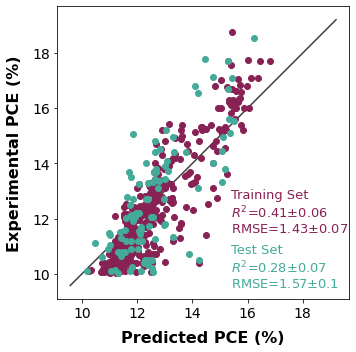

In [11]:
rf_model =RandomForestRegressor(n_estimators=80,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
ann_model = MLPRegressor(hidden_layer_sizes = (50, 50, 50), learning_rate = 'adaptive', random_state=14, max_iter=500)

em_rf_ann = VotingRegressor([('rf', rf_model), ('ann', ann_model)])
em_rf_ann.fit(x_train, y_train.values.ravel())
print('em_rf_ann')
print('training set')
R2_train, R2_SEM_train, RMSE_train, RMSE_SEM_train = model_metrics(em_rf_ann, x_train, y_train, cv=5)
print('test set')
R2_test, R2_SEM_test, RMSE_test, RMSE_SEM_test = model_metrics(em_rf_ann, x_test, y_test, cv=5)

em_rf_ann_predictions_test = em_rf_ann.predict(x_test)
em_rf_ann_predictions_train = em_rf_ann.predict(x_train)
print(em_rf_ann_predictions_test.max())
print(em_rf_ann_predictions_train.max())

fig, ax = plt.subplots(figsize = (5.5, 5))
ax.scatter(em_rf_ann_predictions_train, y_train, color = '#882255')
ax.scatter(em_rf_ann_predictions_test, y_test, color = '#44AA99')


#ax.plot(sTDA_HOMOs_array, m*sTDA_HOMOs_array + b, color='c', linewidth=5)

# x=y line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax.set_ylabel('Experimental PCE (%)', labelpad=10, weight='bold', size=16)
ax.set_xlabel('Predicted PCE (%)', labelpad=10, weight='bold', size=16)
ax.tick_params(axis = 'x', labelsize=14)
ax.tick_params(axis = 'y', labelsize=14)


text_train = 'Training Set\n$R^2$=' + str(R2_train) + '$\pm$' + str(R2_SEM_train) + '\nRMSE=' + str(RMSE_train)+ '$\pm$' + str(RMSE_SEM_train)
text_test = 'Test Set\n$R^2$=' + str(R2_test) + '$\pm$' + str(R2_SEM_test) + '\nRMSE=' + str(RMSE_test)+ '$\pm$' + str(RMSE_SEM_test)

ax.text(15.4, 11.5, text_train, ha='left', size=13, color='#882255')
ax.text(15.4, 9.5, text_test, ha='left', size=13, color='#44AA99')
ax.set_aspect('equal')
plt.tight_layout()

plt.savefig('em_rf_ann_predictions_scatter_MFcounts_standardized.pdf', dpi=600)
plt.savefig('em_rf_ann_predictions_scatter_MFcounts_standardized.png', dpi=600)
plt.show()